# Scenario 4.1 ResNet Graph Analysis


In [12]:
# make sure libs are installed
import sys

!{sys.executable} -m pip install --user --quiet networkx seaborn ipywidgets matplotlib ipycytoscape nbresuse

# make sure jupyter widgets are installed. Sometimes helps to reload the page in the browser.
!{sys.executable} -m jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-cytoscape


Building jupyterlab assets (build:prod:minimize)


In [13]:
#  import spark related modules
import pyspark
import socket
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct
import os , sys
import multiprocessing as mp
import uuid
import networkx as nx
import seaborn
from IPython.display import Markdown, display, HTML
from IPython.display import Javascript, display
from ipywidgets import widgets
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
 
# prevent error on rerunning if session is still alive
if 'sc' in globals():
    sc.stop()
    
# most configuration of the sparksession is done for you in the back
application_name = 'datastory 4 - resnet opportunities'

sparkSession = SparkSession.builder.appName(application_name)\
                           .config('spark.executor.memory', '4g')\
                           .config('spark.executor.instances', '5')\
                           .config('spark.sql.shuffle.partitions', '50')\
                           .config('spark.driver.memory', '4g')\
                           .config('spark.executor.cores', '3')\
                           .config('spark.driver.host', socket.gethostbyname(socket.gethostname()))\
                           .getOrCreate()

sc = sparkSession.sparkContext
sc

<SparkContext master=k8s://https://kubernetes.default.svc.cluster.local:443 appName=datastory 4 - resnet opportunities>

In [14]:
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import upper
from pyspark.sql.functions import lower
from pyspark.sql.functions import explode
from pyspark.sql.functions import col
from pyspark.sql.functions import split
from pyspark.sql.functions import countDistinct

### Given a list of proteins match them to entities in the protein table

In [15]:
hdfs_path = "hdfs://demo-full-load-hdfs-namenode:8020"
data_path = hdfs_path + '/resnet/' 

def protein_df():
    file = data_path+'elsevier-csv-resnet-protein_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file) \
            .select(["Protein", "hasName", "hasProperty", "isMemberOf", "isPartnerOf"])

def disease_regulation_df():
    file = data_path+'elsevier-csv-resnet-regulation_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file)


def disease_expression_df():
    file = data_path+'elsevier-csv-resnet-expression_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file)

def direct_regulation_df():
    file = data_path+'elsevier-csv-resnet-directregulation_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file)

def binding_df():  # not sure we need this
    file = data_path+'elsevier-csv-resnet-binding_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file)

def disease_df():
    file = data_path+'elsevier-csv-resnet-disease_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file) \
            .select(["Disease", "hasName", "hasProperty", "isMemberOf", "isTargetOf"])

def smallmol_with_binding_df():
    file = data_path+'elsevier-csv-resnet-smallmol_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file) \
            .select(["SmallMol", "hasName", "isPartnerOf"])\
            .dropna(subset=["isPartnerOf"]) \
            .withColumn("isPartnerOf_sm", explode(split(col("isPartnerOf"), "\\|\\|")).alias("isPartnerOf_sm"))\
            .drop("isPartnerOf")

def target_proteins_df():
    prots = protein_df().withColumn("isPartnerOf", explode(split(col("isPartnerOf"), "\\|\\|")).alias("isPartnerOf"))
    smallmols = smallmol_with_binding_df()
    
    prots = prots.join(smallmols.select(["isPartnerOf_sm", "SmallMol"]), prots.isPartnerOf == smallmols.isPartnerOf_sm, 'left')
    prots = prots.dropna(subset=["SmallMol"])
    prots = prots.drop(*["isPartnerOf", "SmallMol", "isPartnerOf_sm"]).drop_duplicates()
    
    return prots

def get_prot_bindings_from_prot_df(proteins):
    prot_1 = proteins.alias("prot_1")
    prot_2 = proteins.alias("prot_2") \
                .withColumnRenamed("hasName", "hasName2") \
                .withColumnRenamed("Protein", "Protein2") \
                .select(["Protein2", "hasName2", "isPartnerOf"])
    
    protein_bindings = prot_1.join(prot_2, prot_1.isPartnerOf == prot_2.isPartnerOf, "inner")
    protein_bindings = protein_bindings.drop_duplicates(["Protein", "Protein2"])
    return protein_bindings

def protein_binding_interactions_df():
    proteins = protein_df()
    proteins = proteins.withColumn("isPartnerOf", explode(split(col("isPartnerOf"), "\\|\\|")).alias("isPartnerOf"))
    
    return get_prot_bindings_from_prot_df(proteins)


def dictvalue_df():
    file = data_path+'elsevier-csv-resnet-dictvaluetype_deduplicated/*.csv'
    return sparkSession \
            .read \
            .option("header","true") \
            .csv(file)


In [16]:
disease_df().limit(10).toPandas()

,Disease,hasName,hasProperty,isMemberOf,isTargetOf
0,https://data.elsevier.com/lifescience/entity/r...,adjustment disorder,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...
1,https://data.elsevier.com/lifescience/entity/r...,viral arthritis,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...
2,https://data.elsevier.com/lifescience/entity/r...,cervicobrachialgia,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...
3,https://data.elsevier.com/lifescience/entity/r...,neoplasm,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...
4,https://data.elsevier.com/lifescience/entity/r...,lingual neoplasm,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...
5,https://data.elsevier.com/lifescience/entity/r...,brain laceration,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...,None
6,https://data.elsevier.com/lifescience/entity/r...,lateral sinus septic phlebitis,https://data.elsevier.com/lifescience/entity/r...,None,None
7,https://data.elsevier.com/lifescience/entity/r...,infantile Krabbe disease,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...
8,https://data.elsevier.com/lifescience/entity/r...,adult stuttering,https://data.elsevier.com/lifescience/entity/r...,None,https://data.elsevier.com/lifescience/entity/r...
9,https://data.elsevier.com/lifescience/entity/r...,spasmodic torticollis,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...


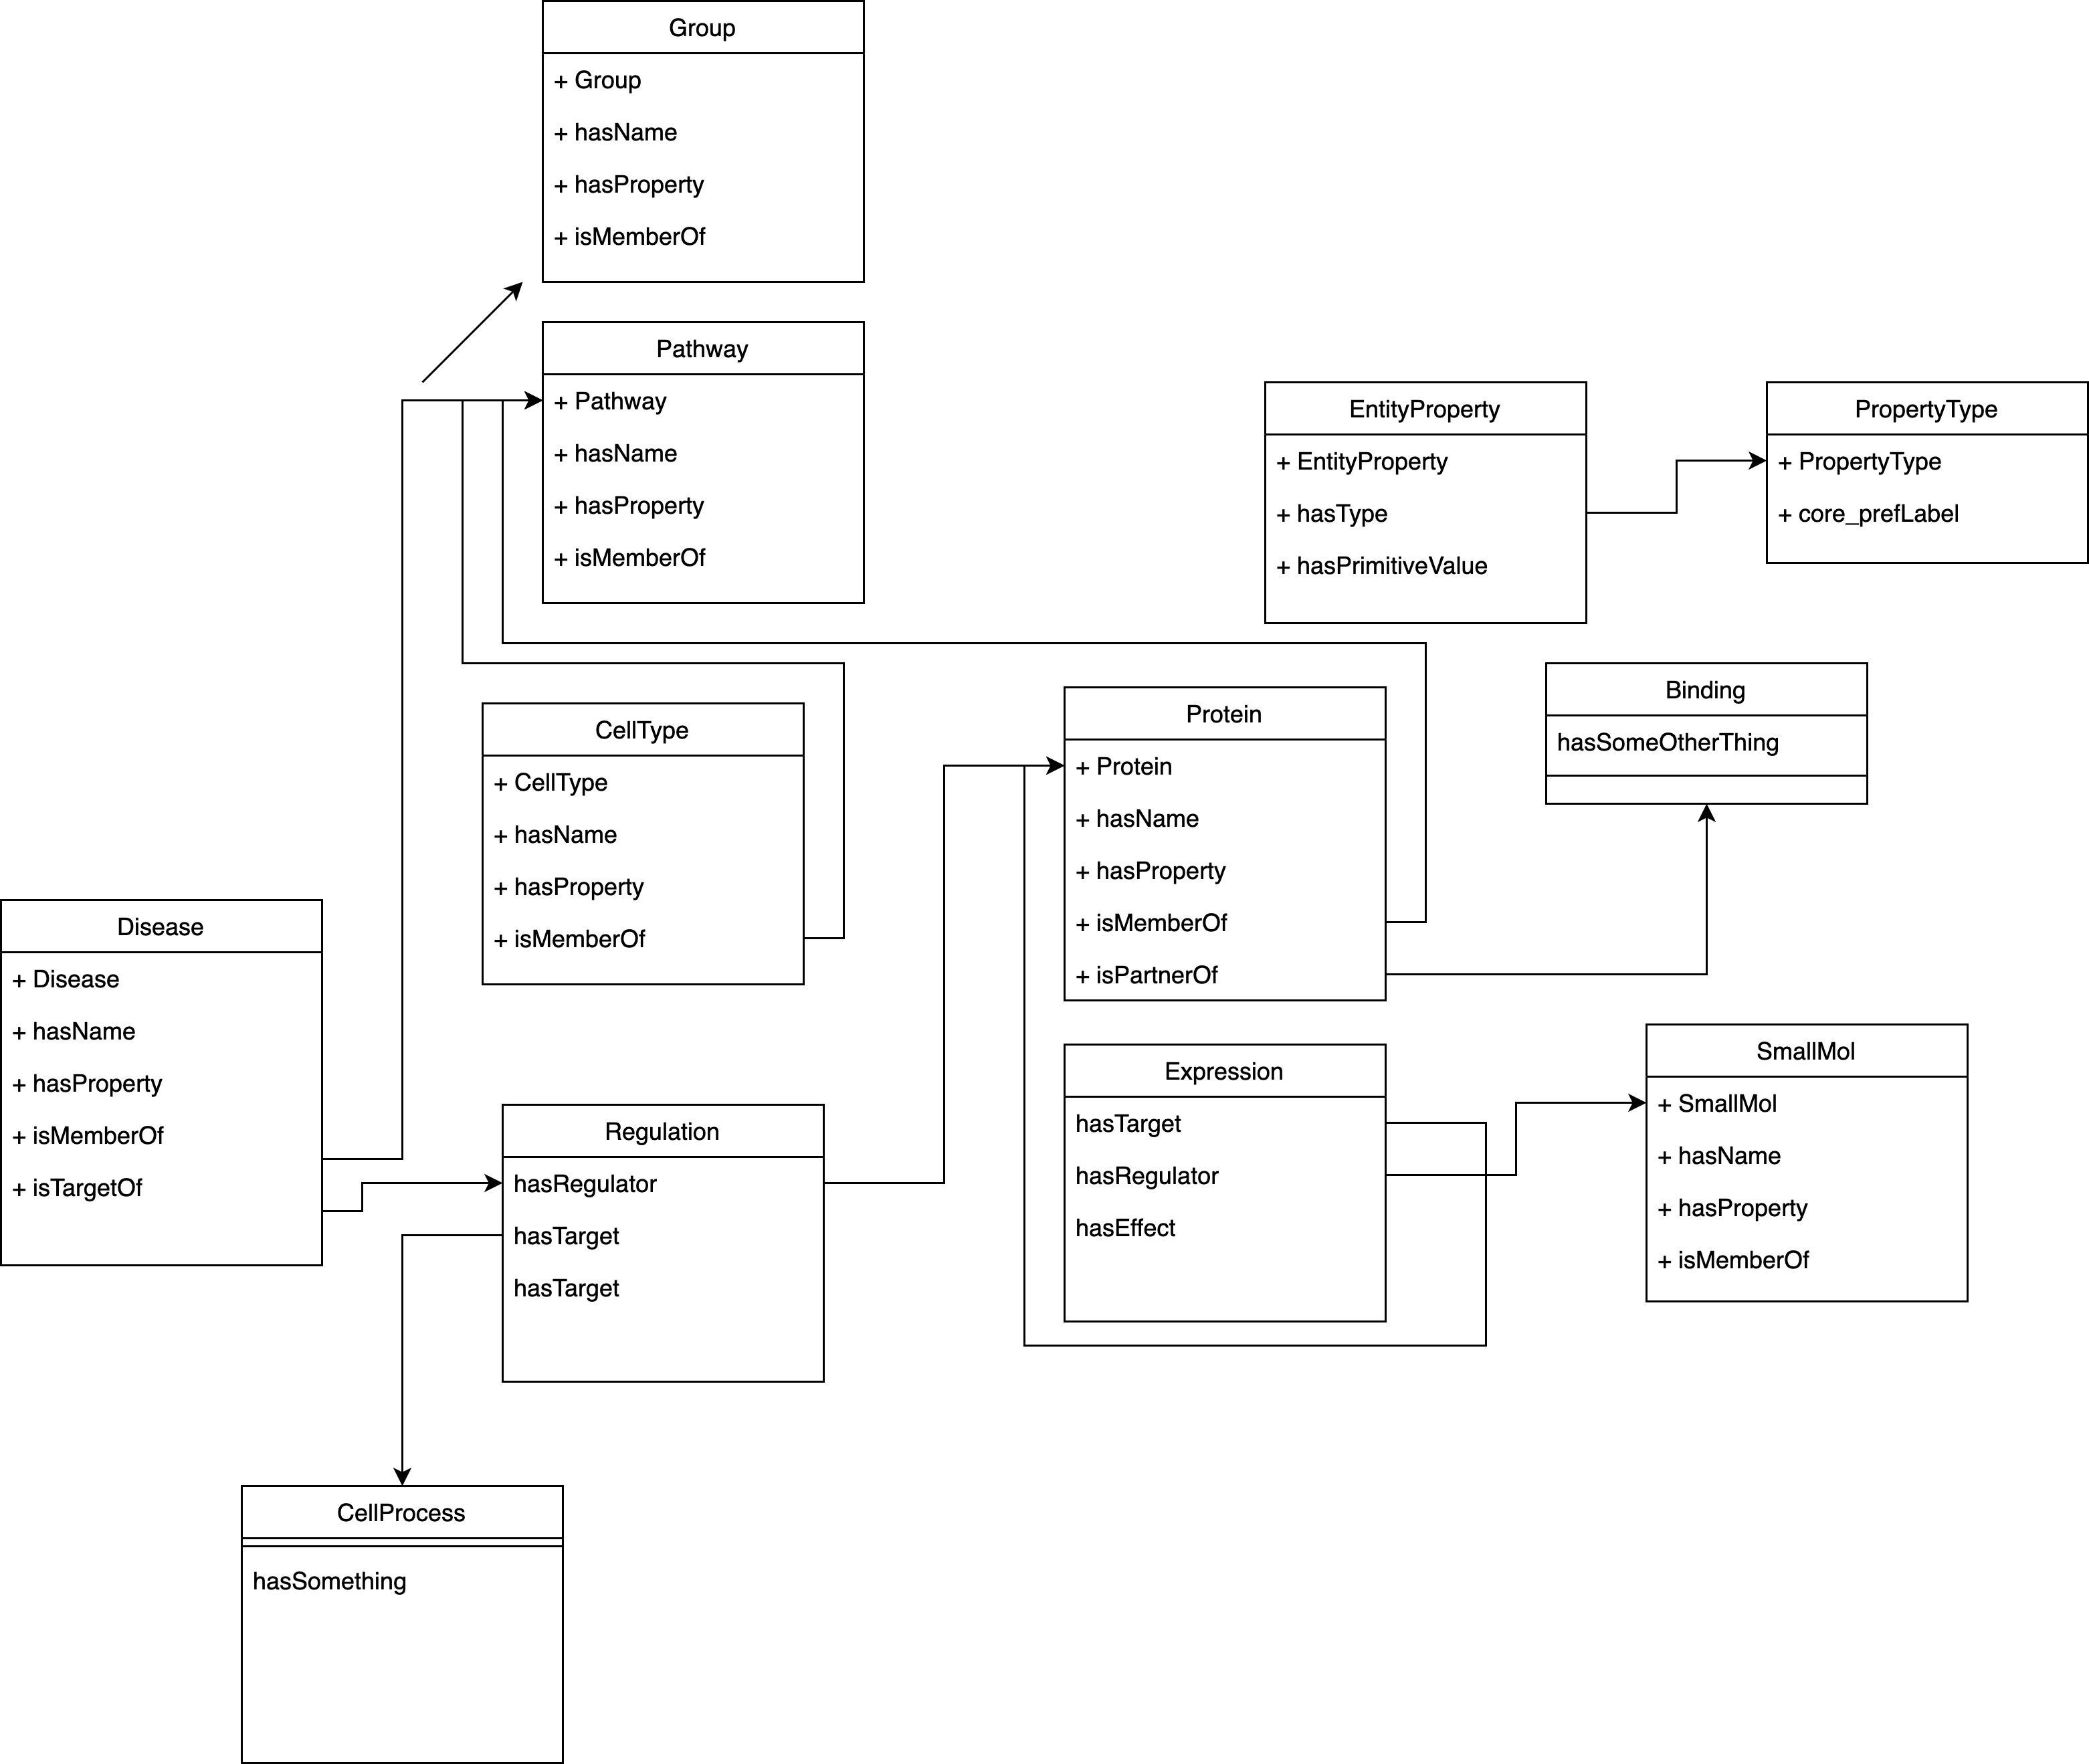

In [17]:
from IPython.display import Image
Image(filename="./resnet_classes_overview.png")

# Network Builder

In [18]:
import logging

pyspark_log = logging.getLogger('pyspark').setLevel(logging.ERROR)
py4j_logger = logging.getLogger("py4j").setLevel(logging.ERROR)


loggers = {}

def get_logger(logger_name):
        # create logger for prd_ci
        if loggers.get(logger_name):
            return loggers.get(logger_name)
        else:
            log = logging.getLogger(logger_name)
            log.setLevel(level=logging.INFO)

            # create formatter and add it to the handlers
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')


            # reate console handler for logger.
            ch = logging.StreamHandler()
            ch.setLevel(level=logging.INFO)
            ch.setFormatter(formatter)

            log.addHandler(ch)
            loggers[logger_name] = log
            return log
        


In [19]:
def get_diseases_for_term(term: str):
    diseases = disease_df().select(["Disease", "hasName"])
    
    return diseases.filter(lower(diseases.hasName).contains(term)).toPandas()
    
    
def populate_disease_widget(term: str):
    diseases = get_diseases_for_term(term)
    
    disease_options = [tuple(x) for x in diseases[['hasName', 'Disease']].values]
    
    return widgets.Dropdown(
        options=disease_options,
        description='Disease'
    )
    

In [20]:

import pandas as pd


class NetworkBuilder():
    def __init__(self):
        self.logger = get_logger("resnet.network_builder")

        self.logger.info("ResNet Network Builder ready.")
        
        
        self.data = None

    def _reset_data(self):
        self.data = None
        
    def filter_on_disease_term(self, term):
        """Returns possible disease terms"""
        return
    
    def search_disease(self, term):
        self.logger.info("Searching for disease {}...".format(term))
        
        diseases = disease_df()
#         return diseases.filter(lower(diseases.hasName).contains(term))
        return diseases.filter(diseases.Disease == term)
    
    def get_regulating_proteins(self, disease_df):
        diseases = disease_df.withColumn("isTargetOf", explode(split(col("isTargetOf"), "\\|\\|")).alias("isTargetOf"))

        regulations = disease_regulation_df().select(["Regulation", "hasRegulator", "hasEffect"])
#         regulations = direct_regulation_df().select(["DirectRegulation", "hasRegulator", "hasEffect"]) \
#                                             .withColumnRenamed("DirectRegulation", "Regulation")
        
        dict_value_df = dictvalue_df().select(["DictValueType", "core_prefLabel"]).withColumnRenamed("core_prefLabel", "EffectLabel")
        
        regulations = regulations.join(dict_value_df, regulations.hasEffect == dict_value_df.DictValueType, "left")
        regulations = regulations.drop(*["DictValueType", "hasEffect"])

        
        diseases_w_regulation = diseases.join(regulations, diseases.isTargetOf == regulations.Regulation, 'left')
        
        diseases_w_regulation.withColumn("hasRegulator", explode(split(col("hasRegulator"), "\\|\\|")).alias("hasRegulator"))
        
        proteins = protein_df().select(["Protein", "hasName", "isPartnerOf"]).withColumnRenamed("hasName", "ProteinName")
        
        targets = target_proteins_df().select(["Protein"]).withColumnRenamed("Protein", "Target")
        proteins = proteins.join(targets, proteins.Protein == targets.Target, "inner").drop("Target")
        
        diseases_w_regulating_protein = diseases_w_regulation.join(proteins, diseases_w_regulation.hasRegulator == proteins.Protein )
        diseases_w_regulating_protein = diseases_w_regulating_protein.drop(*["isTargetOf", "Regulation", "hasRegulator"])
        diseases_w_regulating_protein = diseases_w_regulating_protein.drop_duplicates()
        
        return diseases_w_regulating_protein
    
    def get_binding_proteins(self, disease_regulators):
        regulating_proteins = disease_regulators.select(["Protein", "ProteinName", "isPartnerOf"])\
                        .withColumn("isPartnerOf", explode(split(col("isPartnerOf"), "\\|\\|")).alias("isPartnerOf"))
        
        binding_proteins = protein_df()
        targets = target_proteins_df().select(["Protein"]).withColumnRenamed("Protein", "Target")
        binding_proteins = binding_proteins.join(targets, binding_proteins.Protein == targets.Target, "inner").drop("Target")

        binding_proteins = binding_proteins \
                    .withColumn("isPartnerOf", explode(split(col("isPartnerOf"), "\\|\\|")).alias("isPartnerOf")) \
                    .withColumnRenamed("hasName", "hasName2") \
                    .withColumnRenamed("Protein", "Protein2") \
                    .select(["Protein2", "hasName2", "isPartnerOf"])

        protein_bindings = regulating_proteins.join(
            binding_proteins, regulating_proteins.isPartnerOf == binding_proteins.isPartnerOf, "inner")
        protein_bindings = protein_bindings.drop_duplicates().drop_duplicates(subset=["Protein", "Protein2"])
        return protein_bindings
    
    def query(self, disease_uri):
        self._reset_data()
        
        self.logger.info("Building network for {}...".format(disease_uri))
        
        diseases = self.search_disease(disease_uri)
        
        disease_regulators = self.get_regulating_proteins(diseases)
        
        disease_regulator_count = disease_regulators.count()
        self.logger.info("Found {} disease regulators...".format(disease_regulator_count))
        
        if disease_regulator_count < 1:
            self.logger.info("No results for query...")
            return None, None
        
        binding_proteins = self.get_binding_proteins(disease_regulators)
        
        self.logger.info("Found {} binding protein relationships...".format(binding_proteins.count()))

        return disease_regulators, binding_proteins

        

In [21]:
def preprocess_network_data(disease_regulators, binding_proteins, regulation_widgets, n_sample = None):
    # reformat disease regs
    disease_regs_pd = disease_regulators.dropna(subset=["Disease", "hasName", "Protein", "ProteinName"])
    
    records_count = len(disease_regs_pd)
    
    if n_sample is not None and (n_sample > 0 and n_sample <= records_count):
        disease_regs_pd = disease_regs_pd.sample(n=n_sample)

    disease_nodes = disease_regs_pd[["Disease", "hasName"]].drop_duplicates()
    protein_nodes = disease_regs_pd[["Protein", "ProteinName"]].drop_duplicates()

    regulator_edges = disease_regs_pd.loc[:, ["Disease", "Protein", "EffectLabel"]]
    regulator_edges["EffectLabel"] = regulator_edges["EffectLabel"].fillna("unknown")
    
    print("In disease regulating network: {} disease nodes, {} protein nodes, {} regulation edges".format(
        len(disease_nodes), len(protein_nodes), len(regulator_edges)))
    
    # reformat binding prots
    binding_prots_pd = binding_proteins.toPandas()\
                    .dropna(subset=["Protein","ProteinName", "Protein2", "hasName2"])\
                    .drop_duplicates(subset=["Protein", "Protein2"])

    binding_prots_pd = binding_prots_pd[
        binding_prots_pd["Protein"].isin(protein_nodes.Protein.values) |
        binding_prots_pd["Protein2"].isin(protein_nodes.Protein.values)].reset_index(drop=True)

    binding_protein_nodes = pd.concat([
        binding_prots_pd[["Protein", "ProteinName"]].copy(),
        binding_prots_pd[["Protein2", "hasName2"]].copy().rename(columns={"Protein2": "Protein", "hasName2": "ProteinName"})
    ], axis=0).drop_duplicates().reset_index(drop=True)

    binding_protein_nodes = binding_protein_nodes.dropna(subset=["Protein", "ProteinName"])

    binding_protein_edges = binding_prots_pd[["Protein", "Protein2"]].dropna().drop_duplicates(subset=["Protein", "Protein2"])

    binding_protein_edges = binding_protein_edges[
        binding_protein_edges.Protein.isin(protein_nodes.Protein.values) |
        binding_protein_edges.Protein2.isin(protein_nodes.Protein.values)
    ]
    print("In binding protein network: {} protein nodes, {} binding edges".format(
        len(binding_protein_nodes), len(binding_protein_edges)))
    
    return {
        "disease_nodes": disease_nodes,
        "protein_nodes": protein_nodes,
        "regulator_edges": regulator_edges,
        "binding_protein_nodes": binding_protein_nodes,
        "binding_protein_edges": binding_protein_edges
    }
    


def build_nx_graph(disease_regulators, binding_proteins, regulation_widgets, n_sample = None):
    
    nw_data = preprocess_network_data(disease_regulators, binding_proteins, regulation_widgets, n_sample)
    
    disease_nodes = nw_data.get("disease_nodes")
    protein_nodes = nw_data.get("protein_nodes")
    regulator_edges = nw_data.get("regulator_edges")
    binding_protein_nodes = nw_data.get("binding_protein_nodes")
    binding_protein_edges = nw_data.get("binding_protein_edges")

    # actually build graph from nodes and edges dfs
    
    G = nx.DiGraph()

    G.add_nodes_from(disease_nodes.Disease.values)
    G.add_nodes_from(protein_nodes.Protein.values)

    effect_label_dict = {
        "positive": "P",
        "negative": "N",
        "unknown": "U"
    }

    applied_values = []


    for effect in regulator_edges["EffectLabel"].unique():
        regulator_w_effect = regulator_edges[
            regulator_edges["EffectLabel"] == effect]
        
        G.add_edges_from(regulator_w_effect[["Disease", "Protein"]].values, edge_type=effect_label_dict[effect])
            

    nx.set_node_attributes(G, pd.Series(disease_nodes.hasName.values, index=disease_nodes.Disease).to_dict(), 'name')
    nx.set_node_attributes(G, pd.Series('disease', index=disease_nodes.Disease).to_dict(), 'node_type')
    nx.set_node_attributes(G, pd.Series("#DD403A", index=disease_nodes.Disease).to_dict(), 'color')

    nx.set_node_attributes(G, pd.Series(protein_nodes.ProteinName.values, index=protein_nodes.Protein).to_dict(), 'name')
    nx.set_node_attributes(G, pd.Series('protein', index=protein_nodes.Protein).to_dict(), 'node_type')

    G.add_nodes_from(binding_protein_nodes.Protein.values)
    G.add_edges_from(binding_protein_edges.values, edge_type='b')

    nx.set_node_attributes(G, pd.Series(binding_protein_nodes.ProteinName.values, index=binding_protein_nodes.Protein).to_dict(), 'name')
    nx.set_node_attributes(G, pd.Series('protein', index=binding_protein_nodes.Protein).to_dict(), 'node_type')

    nx.set_node_attributes(G, pd.Series("#003f5c", index=binding_protein_nodes.Protein).to_dict(), 'color')
    nx.set_node_attributes(G, pd.Series('#ffa600', index=protein_nodes.Protein).to_dict(), 'color')
    
    return G


In [22]:

__all__ = ["cytoscape_data", "cytoscape_graph"]

_attrs = dict(name="name", ident="id")



def cytoscape_data(G, attrs=None):
    """Returns data in Cytoscape JSON format (cyjs).

    Parameters
    ----------
    G : NetworkX Graph


    Returns
    -------
    data: dict
        A dictionary with cyjs formatted data.
    Raises
    ------
    NetworkXError
        If values in attrs are not unique.
    """
    if not attrs:
        attrs = _attrs
    else:
        attrs.update({k: v for (k, v) in _attrs.items() if k not in attrs})

    name = attrs["name"]
    ident = attrs["ident"]

    if len({name, ident}) < 2:
        raise nx.NetworkXError("Attribute names are not unique.")

    jsondata = {"data": list(G.graph.items())}
    jsondata["directed"] = G.is_directed()
    jsondata["multigraph"] = G.is_multigraph()
    jsondata["elements"] = {"nodes": [], "edges": []}
    nodes = jsondata["elements"]["nodes"]
    edges = jsondata["elements"]["edges"]

    for i, j in G.nodes.items():
        n = {"data": j.copy()}
        n["data"]["id"] = j.get(ident) or str(i)
        n["data"]["value"] = i
        n["data"]["name"] = j.get(name) or str(i)
        nodes.append(n)

    if G.is_multigraph():
        for e in G.edges(keys=True):
            n = {"data": G.adj[e[0]][e[1]][e[2]].copy()}
            n["data"]["source"] = e[0]
            n["data"]["target"] = e[1]
            n["data"]["key"] = e[2]
            edges.append(n)
    else:
        for e in G.edges():
            n = {"data": G.adj[e[0]][e[1]].copy()}
            n["data"]["source"] = e[0]
            n["data"]["target"] = e[1]
            edges.append(n)
    return jsondata


# Start

First, instantiate the network builder:

In [23]:
nw_builder = NetworkBuilder()

2020-09-09 14:45:29,370 - resnet.network_builder - INFO - ResNet Network Builder ready.


This builder contains the functionality to retrieve:

- a disease
- it's regulating proteins
- proteins that bind to the regulating proteins

This is a subset of proteins that also has a binding with a small molecule, and such can be interpreted as a target.

In [24]:
# Enter a search term, which will populate a dropdown

DISEASE_TERM = 'pancreatitis'

disease_widget = populate_disease_widget(DISEASE_TERM)
display(disease_widget)

Dropdown(description='Disease', options=(('autosomal dominant hereditary pancreatitis', 'https://data.elsevier…

After selecting a disease from the dropdown, execute the following cell to run the query:

In [25]:
disease_regs, binding_prots = nw_builder.query(disease_widget.value)

2020-09-09 14:45:43,752 - resnet.network_builder - INFO - Building network for https://data.elsevier.com/lifescience/entity/resnet/disease/72057594038171920...
2020-09-09 14:45:43,753 - resnet.network_builder - INFO - Searching for disease https://data.elsevier.com/lifescience/entity/resnet/disease/72057594038171920...
2020-09-09 14:45:57,326 - resnet.network_builder - INFO - Found 147 disease regulators...
2020-09-09 14:46:08,702 - resnet.network_builder - INFO - Found 7554 binding protein relationships...


Inspect disease regulators

In [26]:
disease_regs.select(["Disease", "hasName", "EffectLabel", "Protein", "ProteinName"]).limit(5).toPandas()

,Disease,hasName,EffectLabel,Protein,ProteinName
0,https://data.elsevier.com/lifescience/entity/r...,chronic pancreatitis,negative,https://data.elsevier.com/lifescience/entity/r...,IGF1
1,https://data.elsevier.com/lifescience/entity/r...,chronic pancreatitis,negative,https://data.elsevier.com/lifescience/entity/r...,CBS
2,https://data.elsevier.com/lifescience/entity/r...,chronic pancreatitis,None,https://data.elsevier.com/lifescience/entity/r...,CLDN2
3,https://data.elsevier.com/lifescience/entity/r...,chronic pancreatitis,None,https://data.elsevier.com/lifescience/entity/r...,EPHX2
4,https://data.elsevier.com/lifescience/entity/r...,chronic pancreatitis,positive,https://data.elsevier.com/lifescience/entity/r...,IL2RA


Inspect binding proteins

In [27]:
binding_prots.select(["Protein","ProteinName", "Protein2", "hasName2"]).limit(5).toPandas()

,Protein,ProteinName,Protein2,hasName2
0,https://data.elsevier.com/lifescience/entity/r...,ADRB2,https://data.elsevier.com/lifescience/entity/r...,SLC25A6
1,https://data.elsevier.com/lifescience/entity/r...,ADRB2,https://data.elsevier.com/lifescience/entity/r...,ATP2B4
2,https://data.elsevier.com/lifescience/entity/r...,ADRB2,https://data.elsevier.com/lifescience/entity/r...,ATP5O
3,https://data.elsevier.com/lifescience/entity/r...,ADRB2,https://data.elsevier.com/lifescience/entity/r...,CEACAM1
4,https://data.elsevier.com/lifescience/entity/r...,ADRB2,https://data.elsevier.com/lifescience/entity/r...,PON2


## Build graph from builder output

In [28]:
from ipycytoscape import *
import ipycytoscape

In [29]:
pos_regulation = widgets.Checkbox(
    value=True,
    description='Positive',
    disabled=False,
    indent=False
)

neg_regulation = widgets.Checkbox(
    value=True,
    description='Negative',
    disabled=False,
    indent=False
)

none_regulation = widgets.Checkbox(
    value=True,
    description='Unknown',
    disabled=False,
    indent=False
)

Select which types of regulations to include (helps to narrow down network results)

In [30]:
items = [pos_regulation, neg_regulation, none_regulation]
regulation_widgets = widgets.VBox(items)
display(regulation_widgets)

In [31]:
disease_regs_pd = disease_regs.toPandas()

def apply_regulation_widget_filter(df, widgets):
    
    filter_values = ['positive', 'negative', None]
    
    applied_values = []
    
    for idx, widget in enumerate(widgets.children):
        if widget.value:
            applied_values.append(filter_values[idx])
    
    return df[df.EffectLabel.isin(applied_values)]
    

    
disease_regs_pd = apply_regulation_widget_filter(disease_regs_pd, regulation_widgets)

print("After filtering there are {} regulators".format(len(disease_regs_pd)))

After filtering there are 147 regulators


In [32]:
regulation_graph = build_nx_graph(disease_regs_pd, binding_prots, regulation_widgets, n_sample=5)

In disease regulating network: 1 disease nodes, 5 protein nodes, 5 regulation edges
In binding protein network: 165 protein nodes, 170 binding edges


In [33]:
undirected = ipycytoscape.CytoscapeWidget()

graph_size = regulation_graph.number_of_nodes()

print("{} nodes in network".format(graph_size))

if graph_size > 400:
    raise ValueError("Graph is too large: {}".format(graph_size))
else:
#     undirected.graph.add_graph_from_networkx(G)

    json_data = cytoscape_data(regulation_graph)['elements']
    undirected.graph.add_graph_from_json(json_data)


166 nodes in network


In [34]:
undirected.set_tooltip_source('name')

# maxSimulationTime is in mS
undirected.set_layout(name='cola', nodeSpacing=5, maxSimulationTime=12000)

undirected.set_style([{
                        'selector': 'node',
                        'css': {
                            'background-color': 'data(color)',
                            'label': 'data(name)'
                            }
                        },
                        {
                        'selector': 'node:parent',
                        'css': {
                            'background-opacity': 0.333
                            }
                        },
                        {
                        'selector': 'edge',
                        'css': {
                            'background-opacity': 0.333,
                            'label': 'data(edge_type)'
                            }
                        }])

In [35]:
# execute to re-center
undirected

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 5, 'maxSimulationTime': 12000}, cytoscape_sty…

- positive regulations are indicated with 'P'
- negative regulations are indicated with 'N'
- unknown type regulations are indicated with 'U'
- binding relationships are indicated with 'b'

------